# 16-6. 프로젝트 - Movielens 영화 SBR
- 이번에 우리는 Movielens 1M Dataset을 기반으로, Session based Recommendation 시스템을 제작해 보겠습니다.

****
### 코드 목차
**Step 1. 데이터의 전처리**
- 1-1. Data Load
  - (1) UTC Time 형식인 Time 컬럼을 Pandas dataetime 객체로 변경
  - (2) 데이터 확인
  - (3) Rating값 2 이하인 행을 데이터에서 제외
  - (4) Session 구성
    - 1) UserId=1 인 데이터의 시각(Time) 확인
    - 2) Time 열 기준으로 데이터 확인
    - 3) 시각을 1분 단위로 표시
    - 4) UserId별 1분 단위를 하나의 Session으로 하여 SessionId 생성
- 1-2. Session Length
- 1-3. Session Time
- 1-4. Data Cleansing
- 1-5. Train/Valid/Test Split

(이하 교재 내용과 동일)
**Step 2. 미니 배치의 구성**
- 2-1. Session Dataset
- 2-2. Session DataLoader 

**Step 3. 모델 구성**
- 3-1. Evaluation Metric
- 3-2. Model Architecture

**Step 4. 모델 학습**

**Step 5. 모델 테스트**  

****

- 주요 라이브러리 Import

In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

1) 데이터 확인
- \$ ls -l ~/data

2) 프로젝트 폴더 생성
- \$ mkdir -p ~/aiffel/yoochoose

3) 프로젝트 폴더로 데이터 폴더 링크 연결
- \$ ln -s ~/data/* ~/aiffel/yoochoose/data

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


- 여기서 이전 실습 내역과 가장 크게 다른 부분은 바로 SessionID 대신 UserID 항목이 들어갔다는 점입니다.
  - 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 
  - 그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.

- Rating 정보가 포함되어 있습니다. 
  - 이전 실습 내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있습니다. 
  - 하지만, 직전에 봤던 영화가 맘에 들었는지가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 
  - 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.

- Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초 단위 시간이 기재되어 있습니다.
<br> <br> 
- 위와 같은 정보를 바탕으로 오늘의 실습과정과 유사한 프로젝트 과정을 진행해 보겠습니다.

# Step 1. 데이터의 전처리
위와 같이 간단히 구성해 본 데이터셋을 꼼꼼히 살펴보면서 항목별 기본 분석, session length, session time, cleaning 등의 작업을 진행합니다.
특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, **이를 Session 단위로 어떻게 해석할지**에 주의합니다.

## 1-1. Data Load
- 데이터를 불러와 살펴보고 주요 통계치들 확인
  - 컬럼명: UserId, ItemId, Rating, Time

### (1) UTC Time 형식인 Time 컬럼을 Pandas datetime 객체로 변경
  - 시간 관련 정보 확인

In [3]:
# UTC Time 형식인 Time 컬럼을 datetime 객체로 변경
data['Time'] = data['Time'].apply(lambda x:dt.datetime.utcfromtimestamp(int(x)))

# 시간 관련 정보 확인
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)
data.head()

2000-04-25 23:05:32
2003-02-28 17:49:50


,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43


### (2) 데이터 확인

In [4]:
print(data.shape)
print(data.info())

(1000209, 4)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 31 to 1000042
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   UserId  1000209 non-null  int32         
 1   ItemId  1000209 non-null  int32         
 2   Rating  1000209 non-null  int32         
 3   Time    1000209 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int32(3)
memory usage: 26.7 MB
None


- 컬럼별 Data Type(Dtype) 확인 및 결측치 없음 확인
- 1백만여 개(1,000,209개)의 데이터

- Unique한 유저 수, 아이템 수 확인, 시각(Time) 수 확인

In [5]:
data['UserId'].nunique(), data['ItemId'].nunique(), data['Time'].nunique()

(6040, 3706, 458455)

- 유저 6,040개, 아이템 3,706개, 시각 457,192개

### (3) Rating값 2 이하인 행을 데이터에서 제외

- 시스템의 목적이 **추천**이므로 Rating값이 2 이하인 것을 추천에서 제외하기 위해 Rating별 데이터 수 확인

In [6]:
count_by_rating = data.groupby('Rating').count()
print(count_by_rating)

        UserId  ItemId    Time
Rating                        
1        56174   56174   56174
2       107557  107557  107557
3       261197  261197  261197
4       348971  348971  348971
5       226310  226310  226310


- Rating값이 3 이상인 행만 data_1으로 저장

In [7]:
data_1 = data[data['Rating'] >= 3]
print(data_1)

         UserId  ItemId  Rating                Time
31            1    3186       4 2000-12-31 22:00:19
22            1    1270       5 2000-12-31 22:00:55
27            1    1721       4 2000-12-31 22:00:55
37            1    1022       5 2000-12-31 22:00:55
24            1    2340       3 2000-12-31 22:01:43
...         ...     ...     ...                 ...
1000019    6040    2917       4 2001-08-10 14:40:29
999988     6040    1921       4 2001-08-10 14:41:04
1000172    6040    1784       3 2001-08-10 14:41:04
1000167    6040     161       3 2001-08-10 14:41:26
1000042    6040    1221       4 2001-08-20 13:44:15

[836478 rows x 4 columns]


### (4) Session 구성

1) "UserId = 1"인 데이터의 시각 확인

In [8]:
print(data_1[data_1['UserId'] == 1])

    UserId  ItemId  Rating                Time
31       1    3186       4 2000-12-31 22:00:19
22       1    1270       5 2000-12-31 22:00:55
27       1    1721       4 2000-12-31 22:00:55
37       1    1022       5 2000-12-31 22:00:55
24       1    2340       3 2000-12-31 22:01:43
36       1    1836       5 2000-12-31 22:02:52
3        1    3408       4 2000-12-31 22:04:35
7        1    2804       5 2000-12-31 22:11:59
47       1    1207       4 2000-12-31 22:11:59
0        1    1193       5 2000-12-31 22:12:40
21       1     720       3 2000-12-31 22:12:40
44       1     260       4 2000-12-31 22:12:40
9        1     919       4 2000-12-31 22:22:48
51       1     608       4 2000-12-31 22:23:18
43       1    2692       4 2000-12-31 22:26:10
41       1    1961       5 2000-12-31 22:26:30
48       1    2028       5 2000-12-31 22:26:59
18       1    3105       5 2000-12-31 22:28:33
11       1     938       4 2000-12-31 22:29:12
14       1    1035       5 2000-12-31 22:29:13
42       1   

2) Time열 기준으로 데이터 확인

In [9]:
data_1.sort_values(by=['Time'], axis=0)

,UserId,ItemId,Rating,Time
1000138,6040,858,4,2000-04-25 23:05:32
1000153,6040,2384,4,2000-04-25 23:05:54
999873,6040,593,5,2000-04-25 23:05:54
1000192,6040,2019,5,2000-04-25 23:06:17
1000007,6040,1961,4,2000-04-25 23:06:17
...,...,...,...,...
825526,4958,3489,4,2003-02-28 17:45:20
825438,4958,1407,5,2003-02-28 17:47:23
825731,4958,2634,3,2003-02-28 17:49:08
825724,4958,3264,4,2003-02-28 17:49:08


- <span style="color:blue">**1)과 2)를 통해 UserID 무관하게 Time 기준 1분 단위로 Session 구성하기로 함**</span>
- <span style="color:blue">세션 기반 추천의 세션 구성으로 적절하다고 판단</span>

3) 시각을 1분 단위로 표시

In [10]:
def sec_min(time):
    return time.strftime('%Y-%m-%d %H:%M')
        
data_1['Time_min'] = data_1['Time'].apply(sec_min)
data_1.head()

,UserId,ItemId,Rating,Time,Time_min
31,1,3186,4,2000-12-31 22:00:19,2000-12-31 22:00
22,1,1270,5,2000-12-31 22:00:55,2000-12-31 22:00
27,1,1721,4,2000-12-31 22:00:55,2000-12-31 22:00
37,1,1022,5,2000-12-31 22:00:55,2000-12-31 22:00
24,1,2340,3,2000-12-31 22:01:43,2000-12-31 22:01


4) **UserId별 1분 단위를 하나의 세션으로 하여 SessionID 생성**

- 데이터를 UserId별 1분 단위로 묶은 후 분 단위로 발생한 아이템 수 확인 

In [11]:
data_min = data_1.groupby(['UserId', 'Time_min'])['ItemId'].count()
data_min

UserId  Time_min        
1       2000-12-31 22:00    4
        2000-12-31 22:01    1
        2000-12-31 22:02    1
        2000-12-31 22:04    1
        2000-12-31 22:11    2
                           ..
6040    2001-08-10 14:36    3
        2001-08-10 14:39    3
        2001-08-10 14:40    1
        2001-08-10 14:41    3
        2001-08-20 13:44    1
Name: ItemId, Length: 265481, dtype: int64

- <span style="color:blue">**data_min 시리즈를 데이터프레임(min_frame)으로 변경**</span>
- <span style="color:blue">**이를 reset_index 해서 Time_min을 컬럼으로 변경 (= reindex_min)**</span>

In [12]:
min_frame = data_min.to_frame()
reindex_min = min_frame.reset_index()
reindex_min

,UserId,Time_min,ItemId
0,1,2000-12-31 22:00,4
1,1,2000-12-31 22:01,1
2,1,2000-12-31 22:02,1
3,1,2000-12-31 22:04,1
4,1,2000-12-31 22:11,2
...,...,...,...
265476,6040,2001-08-10 14:36,3
265477,6040,2001-08-10 14:39,3
265478,6040,2001-08-10 14:40,1
265479,6040,2001-08-10 14:41,3


- <span style="color:blue">**데이터프레임 reindex_min의 index를 Session ID로 사용하기 위해 다시 reset_index**</span>

In [13]:
q = reindex_min.reset_index()
q

,index,UserId,Time_min,ItemId
0,0,1,2000-12-31 22:00,4
1,1,1,2000-12-31 22:01,1
2,2,1,2000-12-31 22:02,1
3,3,1,2000-12-31 22:04,1
4,4,1,2000-12-31 22:11,2
...,...,...,...,...
265476,265476,6040,2001-08-10 14:36,3
265477,265477,6040,2001-08-10 14:39,3
265478,265478,6040,2001-08-10 14:40,1
265479,265479,6040,2001-08-10 14:41,3


- 컬럼명 index를 SessionID로 변경

In [14]:
q = q.rename(columns={'index':'SessionId', 'ItemId':'ItemId_min'})
q

,SessionId,UserId,Time_min,ItemId_min
0,0,1,2000-12-31 22:00,4
1,1,1,2000-12-31 22:01,1
2,2,1,2000-12-31 22:02,1
3,3,1,2000-12-31 22:04,1
4,4,1,2000-12-31 22:11,2
...,...,...,...,...
265476,265476,6040,2001-08-10 14:36,3
265477,265477,6040,2001-08-10 14:39,3
265478,265478,6040,2001-08-10 14:40,1
265479,265479,6040,2001-08-10 14:41,3


- <span style="color:blue">**UserID와 Time_min 컬럼 기준으로 데이터프레임 data_1과 q를 merge 하여 data_final 생성**</span>
  - <span style="color:blue">원천 데이터셋 data_1의 맨 마지막 컬럼으로 SessionId 추가됨</span>
  - ItemId_min은 의미없는 값이므로 사용하지 않을 예정

In [15]:
data_final = data_1.merge(q, on=['UserId', 'Time_min'])
data_final

,UserId,ItemId,Rating,Time,Time_min,SessionId,ItemId_min
0,1,3186,4,2000-12-31 22:00:19,2000-12-31 22:00,0,4
1,1,1270,5,2000-12-31 22:00:55,2000-12-31 22:00,0,4
2,1,1721,4,2000-12-31 22:00:55,2000-12-31 22:00,0,4
3,1,1022,5,2000-12-31 22:00:55,2000-12-31 22:00,0,4
4,1,2340,3,2000-12-31 22:01:43,2000-12-31 22:01,1,1
...,...,...,...,...,...,...,...
836473,6040,2917,4,2001-08-10 14:40:29,2001-08-10 14:40,265478,1
836474,6040,1921,4,2001-08-10 14:41:04,2001-08-10 14:41,265479,3
836475,6040,1784,3,2001-08-10 14:41:04,2001-08-10 14:41,265479,3
836476,6040,161,3,2001-08-10 14:41:26,2001-08-10 14:41,265479,3


- <span style="color:blue">**최종 데이터셋 data 생성**</span>
  - data_final에서 필요한 컬럼만 가져 옴
  - UserId와 Rating은 사용하지 않을 예정이나 참고로 사용할 수도 있어서 유지

In [16]:
data = data_final[['SessionId', 'Time', 'ItemId', 'UserId', 'Rating']]
data

,SessionId,Time,ItemId,UserId,Rating
0,0,2000-12-31 22:00:19,3186,1,4
1,0,2000-12-31 22:00:55,1270,1,5
2,0,2000-12-31 22:00:55,1721,1,4
3,0,2000-12-31 22:00:55,1022,1,5
4,1,2000-12-31 22:01:43,2340,1,3
...,...,...,...,...,...
836473,265478,2001-08-10 14:40:29,2917,6040,4
836474,265479,2001-08-10 14:41:04,1921,6040,4
836475,265479,2001-08-10 14:41:04,1784,6040,3
836476,265479,2001-08-10 14:41:26,161,6040,3


- SessionId 컬럼 기준 정렬해서 데이터 확인 한번 더

In [17]:
data.sort_values(['SessionId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,SessionId,Time,ItemId,UserId,Rating
0,0,2000-12-31 22:00:19,3186,1,4
1,0,2000-12-31 22:00:55,1270,1,5
2,0,2000-12-31 22:00:55,1721,1,4
3,0,2000-12-31 22:00:55,1022,1,5
4,1,2000-12-31 22:01:43,2340,1,3
...,...,...,...,...,...
836473,265478,2001-08-10 14:40:29,2917,6040,4
836474,265479,2001-08-10 14:41:04,1921,6040,4
836475,265479,2001-08-10 14:41:04,1784,6040,3
836476,265479,2001-08-10 14:41:26,161,6040,3


- 최종 세션 수, 아이템 수 확인

In [18]:
data['SessionId'].nunique(), data['ItemId'].nunique()

(265481, 3628)

- 세션 수: 265,481개
- 아이템 수: 3,628개

## 1-2. Session Length
- 각 세션의 클릭 수 확인

In [19]:
session_length = data.groupby('SessionId').size()
session_length

SessionId
0         4
1         1
2         1
3         1
4         2
         ..
265476    3
265477    3
265478    1
265479    3
265480    1
Length: 265481, dtype: int64

- session_length: 해당 세션 사용자의 그 세션 동안의 클릭 횟수

In [20]:
session_length.median(), session_length.mean()

(2.0, 3.1508017522911245)

In [21]:
session_length.min(), session_length.max()

(1, 32)

In [22]:
session_length.quantile(0.999)

16.0

- 각 세션의 길이: 보통 2(중앙값)~3(평균) 정도
- 99.9% 세션은 길이가 16 이하
- 길이가 32인 세션 내용 확인

In [23]:
long_session = session_length[session_length==32].index[0]
data[data['SessionId']==long_session]

,SessionId,Time,ItemId,UserId,Rating
94639,30004,2000-11-29 19:56:21,2054,731,4
94640,30004,2000-11-29 19:56:21,2,731,5
94641,30004,2000-11-29 19:56:21,2087,731,5
94642,30004,2000-11-29 19:56:21,788,731,4
94643,30004,2000-11-29 19:56:21,1654,731,5
94644,30004,2000-11-29 19:56:21,247,731,4
94645,30004,2000-11-29 19:56:21,260,731,3
94646,30004,2000-11-29 19:56:21,2100,731,5
94647,30004,2000-11-29 19:56:21,2105,731,4
94648,30004,2000-11-29 19:56:21,653,731,4


- 2000-11-29 19시56분 21~22초에 UserId 731의 데이터를 일괄 업로드(?)한 것으로 추측됨
- 데이터 수도 적고, 테스트 목적이므로 모든 데이터를 사용

- 세션 길이 시각화: 세션 길이 기준 하위 99.9%까지의 분포 누적합

In [24]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1     0.312290
2     0.516071
3     0.665897
4     0.773144
5     0.849552
6     0.901899
7     0.937125
8     0.960509
9     0.974929
10    0.984210
11    0.990052
12    0.993679
13    0.996116
14    0.997574
15    0.998516
dtype: float64

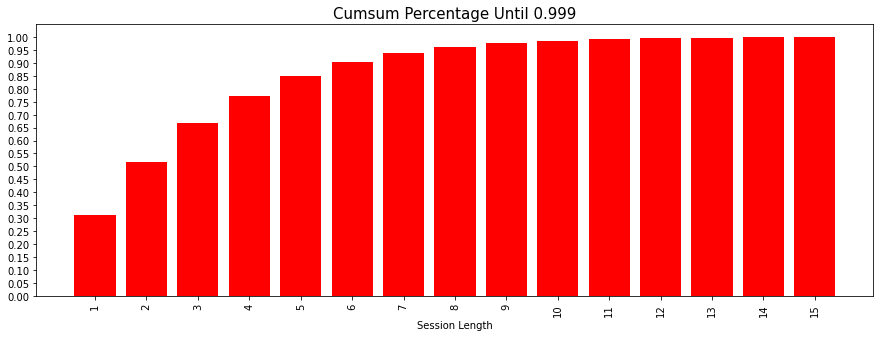

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.bar(x=length_percent_cumsum_999.index, height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index, rotation=90)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.xlabel('Session Length')
plt.title('Cumsum Percentage Until 0.999', size=15)

plt.show()

## 1-3. Session Time

- 데이터의 시간 관련 정보 확인

In [26]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)
print("Data Period:", latest-oldest)

2000-04-25 23:05:32
2003-02-28 17:49:50
Data Period: 1038 days 18:44:18


- 1038/30 = 34.6개월치 데이터
- 데이터 수가 적으므로 전체 데이터 사용

In [27]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

- latest는 Timestamp 객체이기 때문에 int 객체와의 사칙연산을 지원하지 않습니다.
- 날짜끼리의 차이를 구하고 싶을 때는 datetime 라이브러리의 timedelta 객체를 사용합니다.

In [28]:
data.shape

(836478, 5)

- 1038일 분량 데이터 전체를 사용할 것이므로 timedelta값으로 넉넉하게 2000 지정

In [29]:
month_ago = latest - dt.timedelta(2000)     # 최종 날짜로부터 2000일 이전 날짜를 구한다.  
data = data[data['Time'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
data

,SessionId,Time,ItemId,UserId,Rating
0,0,2000-12-31 22:00:19,3186,1,4
1,0,2000-12-31 22:00:55,1270,1,5
2,0,2000-12-31 22:00:55,1721,1,4
3,0,2000-12-31 22:00:55,1022,1,5
4,1,2000-12-31 22:01:43,2340,1,3
...,...,...,...,...,...
836473,265478,2001-08-10 14:40:29,2917,6040,4
836474,265479,2001-08-10 14:41:04,1921,6040,4
836475,265479,2001-08-10 14:41:04,1784,6040,3
836476,265479,2001-08-10 14:41:26,161,6040,3


## 1-4. Data Cleansing
- 길이가 1인 세션 제거
- 너무 적게 클릭된 아이템 제거

In [30]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [31]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,SessionId,Time,ItemId,UserId,Rating
0,0,2000-12-31 22:00:19,3186,1,4
1,0,2000-12-31 22:00:55,1270,1,5
2,0,2000-12-31 22:00:55,1721,1,4
3,0,2000-12-31 22:00:55,1022,1,5
7,4,2000-12-31 22:11:59,2804,1,5
...,...,...,...,...,...
836471,265477,2001-08-10 14:39:27,3671,6040,4
836472,265477,2001-08-10 14:39:58,232,6040,5
836474,265479,2001-08-10 14:41:04,1921,6040,4
836475,265479,2001-08-10 14:41:04,1784,6040,3


In [32]:
data['SessionId'].nunique(), data['ItemId'].nunique()

(182392, 3239)

## 1-5. Train / Valid / Test Split
- 모델 평가를 위한 Valid Set과 Test Set 생성
- 일반적인 경우 train:validation:test = 6:2:2:로 하나, 추천에 사용할 것이므로 (임의로) 8:1:1로 분할하기로 함
  - 1038일 분량의 데이터이므로 train:validation:test = 838:100:100으로 분할

In [33]:
#test_path = data_path / 'yoochoose-test.dat'
#test= load_data(test_path)
#test['Time'].min(), test['Time'].max()

- 가장 마지막 100일 기간 동안을 Test로, 그 다음 100일 기간을 valid set으로 나누기

In [34]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [35]:
tr, test = split_by_date(data, n_days=100)
tr, val = split_by_date(tr, n_days=100)

In [36]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [37]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 747232
	 Sessions: 180657
	 Items: 3239
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-08-12 13:49:48

* valid Set Stats Info
	 Events: 2838
	 Sessions: 911
	 Items: 1358
	 First Time : 2002-08-13 09:05:17
	 Last Time : 2002-11-20 16:38:40

* test Set Stats Info
	 Events: 2612
	 Sessions: 824
	 Items: 1254
	 First Time : 2002-11-21 01:02:06
	 Last Time : 2003-02-28 17:49:50



In [38]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

- 이제 데이터 준비를 마쳤습니다! 데이터를 저장한 다음 data pipeline을 구축하는 단계로 넘어가겠습니다.

In [39]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

# Step 2. 미니 배치의 구성
- 실습 코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. 
  - Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.
  - 단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

## 2-1. SessionDataset
- 데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스를 만듭니다.

In [40]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

- train데이터로 SessionDataset 객체를 만들고 인스턴스 변수들을 살펴보겠습니다.
  - click_offsets 변수는 각 세션이 시작된 인덱스를 담고 있습니다.
  - session_idx 변수는 각 세션을 인덱싱한 np.array 입니다.

In [41]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,SessionId,Time,ItemId,UserId,Rating,item_idx
0,0,2000-12-31 22:00:19,3186,1,4,0
1,0,2000-12-31 22:00:55,1270,1,5,1
2,0,2000-12-31 22:00:55,1721,1,4,2
3,0,2000-12-31 22:00:55,1022,1,5,3
7,4,2000-12-31 22:11:59,2804,1,5,4
8,4,2000-12-31 22:11:59,1207,1,4,5
9,5,2000-12-31 22:12:40,1193,1,5,6
10,5,2000-12-31 22:12:40,720,1,3,7
11,5,2000-12-31 22:12:40,260,1,4,8
14,8,2000-12-31 22:26:10,2692,1,4,9


In [42]:
#click_offsets 변수는 각 세션이 시작된 인덱스를 담고 있습니다.
tr_dataset.click_offsets

array([     0,      4,      6, ..., 747226, 747229, 747232], dtype=int32)

In [43]:
#session_idx 변수는 각 세션을 인덱싱한 np.array 입니다.
tr_dataset.session_idx

array([     0,      1,      2, ..., 180654, 180655, 180656])

## 2-2. SessionDataLoader
- 파이썬 문법 중 iterator, generator에 대한 좀 더 친절한 안내가 필요하신 분은 이 [자료](https://dojang.io/mod/page/view.php?id=2405)를 먼저 보시길 권장합니다.
<br> <br> 
- SessionDataset 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만듭니다.
  - __iter__ 메서드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 yield합니다.
  - mask는 후에 RNN Cell State를 초기화하는데 사용할 것입니다.

In [44]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):   ## 모델 input, label, session이 끝나는 곳의 위치를 생성하는 함수
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [45]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,SessionId,Time,ItemId,UserId,Rating,item_idx
0,0,2000-12-31 22:00:19,3186,1,4,0
1,0,2000-12-31 22:00:55,1270,1,5,1
2,0,2000-12-31 22:00:55,1721,1,4,2
3,0,2000-12-31 22:00:55,1022,1,5,3
7,4,2000-12-31 22:11:59,2804,1,5,4
8,4,2000-12-31 22:11:59,1207,1,4,5
9,5,2000-12-31 22:12:40,1193,1,5,6
10,5,2000-12-31 22:12:40,720,1,3,7
11,5,2000-12-31 22:12:40,260,1,4,8
14,8,2000-12-31 22:26:10,2692,1,4,9


In [46]:
iter_ex = iter(tr_data_loader)

- 아래 셀을 반복 실행하면 next가 계속 다음 데이터를 만듭니다.
- input, output, mask의 감을 잡아 봅시다.

In [47]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [0 4 6 9]
Label Item Idx are :       [ 1  5  7 10]
Previous Masked Input Idx are []


# Step 3. 모델 구성
이 부분도 실습 코드 내역을 참고하여 다양하게 모델 구조를 시도해 볼 수 있습니다.

## 3-1. Evaluation Metric
- 이번 자료에서는 **MRR**(Mean Reciprocal Rank)과 **Recall@k**를 사용하겠습니다. 
  - MRR은 정답 아이템이 나온 순번의 역수 값입니다.
  - 따라서 정답 아이템이 추천 결과 앞쪽 순번에 나온다면 지표가 높아질 것이고 뒤쪽에 나오거나 안 나온다면 지표가 낮아질 것입니다.



In [48]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

## 3-2. Model Architecture
- (교재 내용) GRU4REC 모델 구조를 구현하겠습니다. 모델 구조가 간단한 편이므로 Functional하게 모델을 만들겠습니다.

In [49]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [50]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

- 모델에 사용할 hyper-parameter를 class형식으로 관리하겠습니다.

In [80]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

#args = Args(tr, val, test, batch_size=2048, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)
#args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)
#args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=12, k=20)
#args = Args(tr, val, test, batch_size=512, hsz=50, drop_rate=0.1, lr=0.001, epochs=12, k=20)
#args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=9, k=20)
#args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=17, k=20)
args = Args(tr, val, test, batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=6, k=20)

In [81]:
model = create_model(args)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(32, 1, 3239)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      493650    
_________________________________________________________________
dropout_7 (Dropout)          (32, 50)                  0         
_________________________________________________________________
dense_7 (Dense)              (32, 3239)                165189    
Total params: 658,839
Trainable params: 658,839
Non-trainable params: 0
_________________________________________________________________


# Step 4. 모델 학습
- 다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 
- 실습 코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.

In [82]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)
    
    
def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [83]:
# 모델 학습
train_model(model, args)

Evaluation:  97%|█████████▋| 58/60 [00:08<00:00,  6.49it/s]


	 - Recall@20 epoch 1: 0.154634
	 - MRR@20    epoch 1: 0.047398



Evaluation:  97%|█████████▋| 58/60 [00:08<00:00,  6.73it/s]


	 - Recall@20 epoch 2: 0.173491
	 - MRR@20    epoch 2: 0.052865



Evaluation:  97%|█████████▋| 58/60 [00:08<00:00,  6.69it/s]


	 - Recall@20 epoch 3: 0.173491
	 - MRR@20    epoch 3: 0.053427



Evaluation:  97%|█████████▋| 58/60 [00:08<00:00,  6.62it/s]


	 - Recall@20 epoch 4: 0.182651
	 - MRR@20    epoch 4: 0.057326



Evaluation:  97%|█████████▋| 58/60 [00:08<00:00,  6.75it/s]


	 - Recall@20 epoch 5: 0.181034
	 - MRR@20    epoch 5: 0.057924



Evaluation:  97%|█████████▋| 58/60 [00:08<00:00,  6.55it/s]

	 - Recall@20 epoch 6: 0.183728
	 - MRR@20    epoch 6: 0.058069



# Step 5. 모델 테스트
- 미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

In [84]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation: 100%|██████████| 55/55 [00:07<00:00,  6.92it/s]

	 - Recall@20: 0.234659
	 - MRR@20: 0.079173



# ※ 결과 정리


### 하이퍼 파라미터 설명
- k = 모델이 제시한 아이템 수

### 성능 평가 지표 설명
- Reall@K = 모델이 k개 아이템을 추천했을 때, 실제 True인 데이터를 True라고 인식한 확률
- MRR@K = 모델이 k개 아이템을 추천했을 때, 정답 아이템이 나온 순번의 역수 값

### 실행 결과 정리



| # | 하이퍼 파라미터 | 테스트 결과 | 비고 |
|:---|:---|:---|:---| 
| 1 | batch_size=256, epochs=10, k=20 | Recall@20=0.199, MRR@20=0.064 | |
| 2 | batch_size=256, epochs=12, k=20 | Recall@20=0.208, MRR@20=0.069 | epoch=30으로 실행한 결과 epoch=12에서 정확도 제일 높음 |
| 3 | batch_size=512, epochs=12, k=20 | Recall@20=0.152, MRR@20=0.052 |  |
| 4 | batch_size=128, epochs=9, k=20 | Recall@20=0.221, MRR@20=0.076 | epoch=12로 실행한 결과 epoch=9에서 정확도 제일 높음 |
| **5** | **batch_size=64**, epochs=17, k=20 | **Recall@20=0.243, MRR@20=0.082** | epoch=20으로 실행한 결과 epoch=17에서 정확도 제일 높음 |
| 6 | batch_size=32, epochs=6, k=20 | Recall@20=0.235, MRR@20=0.080 | epoch=20으로 실행한 결과 epoch=6에서 정확도 제일 높음 |

- batch_size=64에서 성능 제일 우수... Recall=0.23 수준에 불과

#### [ #1 ]
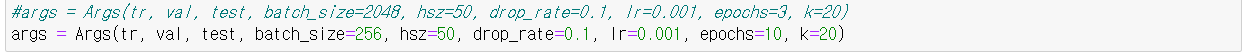
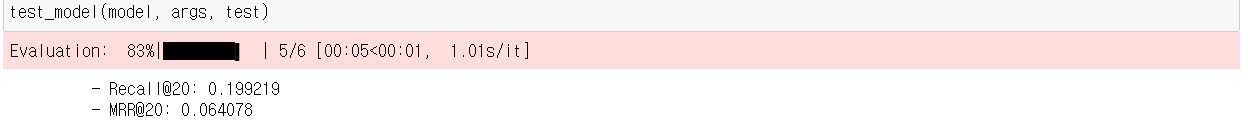

#### [ #2 ] epoch 12에서 정확도 제일 높음
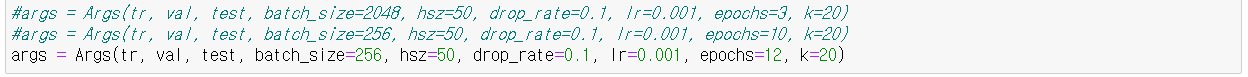
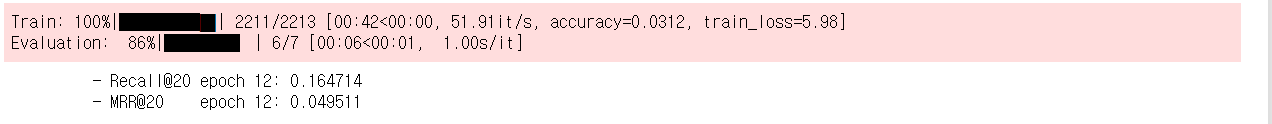
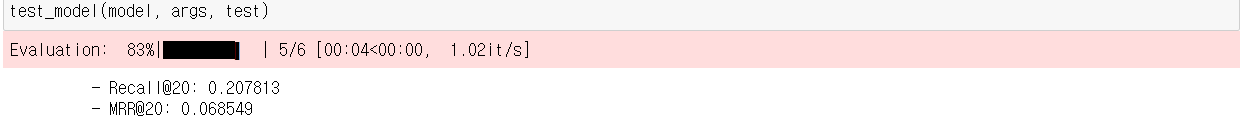

#### [ #3 ] 
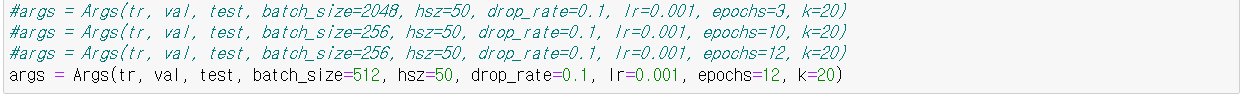
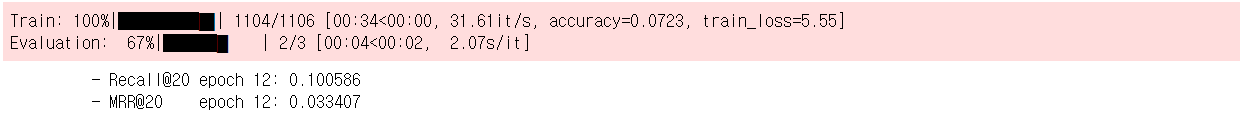
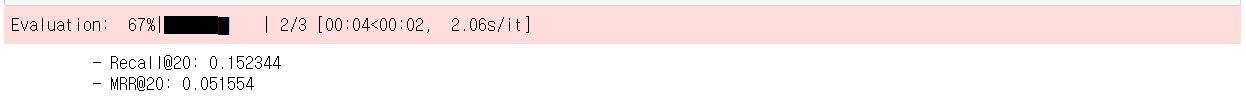

#### [ #4 ] 
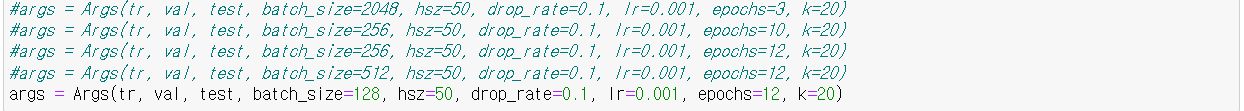
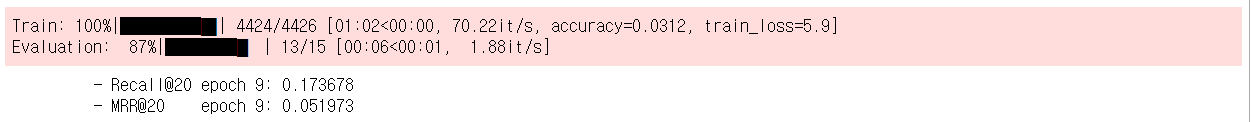
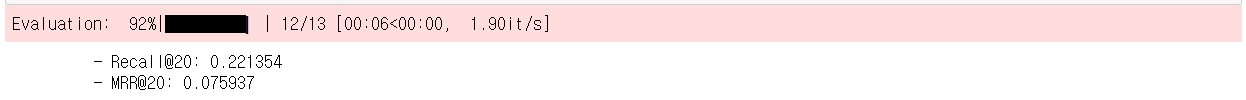

#### [ #5 ] 
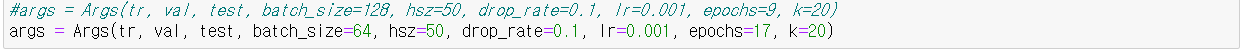
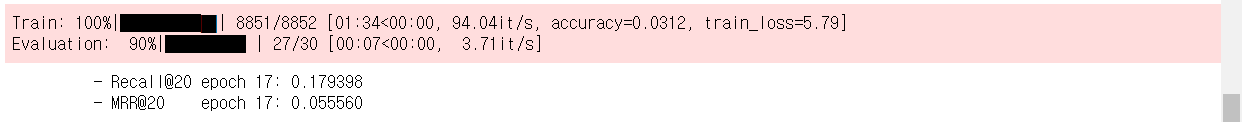
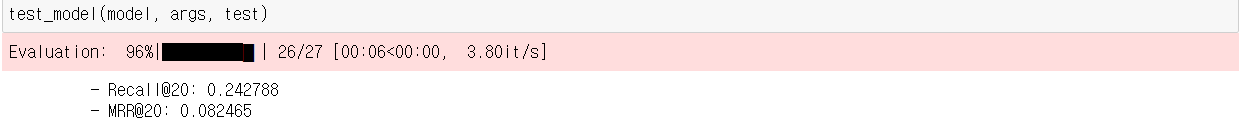

#### [ #6 ] 
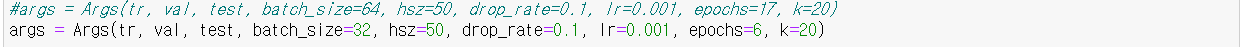
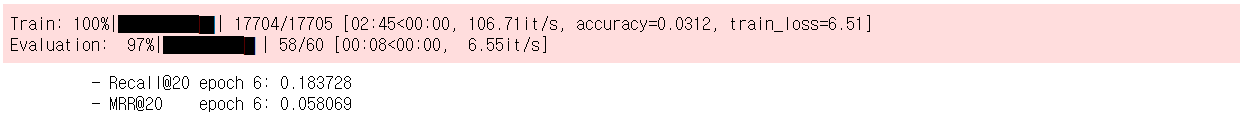
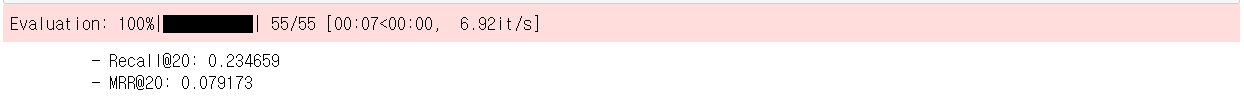

# 프로젝트 평가

| 평가문항 | 상세기준 | 실행 내용 |
|:---|:---|:---|
| 1. Movielens 데이터셋을 session based recommendation <br> 관점으로 전처리하는 과정이 체계적으로 진행되었다. | 데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정 <br> (길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다. | 1-1 부분 참고 |
| 2. RNN 기반의 예측 모델이 정상적으로 구성되어 <br> 안정적으로 훈련이 진행되었다. | 적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 <br> 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 <br> 개선되는 것이 확인된다. | Step 4, 5 참고 |
| 3. 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 <br> 실험하여 Recall, MRR 등의 변화추이를 관찰하였다. | 3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 <br> 분석하였다. | Step 4, 5 참고 |


****
### 코드 목차
**Step 1. 데이터의 전처리**
- 1-1. Data Load
  - (1) UTC Time 형식인 Time 컬럼을 Pandas dataetime 객체로 변경
  - (2) 데이터 확인
  - (3) Rating값 2 이하인 행을 데이터에서 제외
  - (4) Session 구성
    - 1) UserId=1 인 데이터의 시각(Time) 확인
    - 2) Time 열 기준으로 데이터 확인
    - 3) 시각을 1분 단위로 표시
    - 4) UserId별 1분 단위를 하나의 Session으로 하여 SessionId 생성
- 1-2. Session Length
- 1-3. Session Time
- 1-4. Data Cleansing
- 1-5. Train/Valid/Test Split

(이하 교재 내용과 동일)  
**Step 2. 미니 배치의 구성**
- 2-1. Session Dataset
- 2-2. Session DataLoader 

**Step 3. 모델 구성**
- 3-1. Evaluation Metric
- 3-2. Model Architecture

**Step 4. 모델 학습**

**Step 5. 모델 테스트**  

****

## 회고

- Session 구성하는 방법에 대해서는 적절히 이해하고 실행했다고 생각됨
  - UserId별 1분 단위로 세션을 구성하여 인풋 데이터로 사용
  - UserId를 무시하고 1분 단위로 세션을 구성하는 방법도 고려해 볼 수 있음
  - 기능 측면에서는 판다스(Pandas)를 얼마나 잘쓸 수 있는가가 관건임
- Train/Valid/Test Split 관련
  - Train/Valid/Test를 8:1:1로 나누어서 모델 훈련, 검증 및 테스트 진행
  - 영화 추천이므로 영화의 유행 주기와 맞추어 세션 구성 및 데이터를 분할하는 방법이 있을 수 있겠음 
  - 영화 평가 자료를 사용, SBR 모델로 영화 추천하는 것의 정확도가 얼마나 될 지 의문임
    - 위의 실행 결과는 0.23 수준. 기존 다른 모델들의 정확도에 비해 턱없이 낮음
- 모델이 어떻게 작동하는지 이해가 없는 상태로 실행시킴
  - 논문을 읽고 모델을 코딩하여 작동시키고
  - 장단점을 파악하고
  - 여러 변형 모델을 테스트 해보고
  - 개선안도 생각해보고...
  - 할 수 있어야 하는데, 갈 길이 ...
  - 모델 구성을 정확히 파악했다면 Pretrained 모델을 사용할 수도 있었는데 못함
    - 교재와 같이, trained_model을 불러와 실행시켰을 때 에러 발생. 이유를 알 수 없었음
    > \# 학습된 모델을 불러옵니다.<br>
    > model = tf.keras.models.load_model(data_path / 'trained_model')
  - 또한... 아래와 같은 문제에 부딪힘
- 교재에 있는 Argument를 사용해서 실행시 에러 발생
  - 아래 스크린샷 참고
  - batch_size=2048이 문제를 일으킴!!
  - 이유를 찾아낼 수 없어서 다른 사람의 코드를 확인해서 발견 (시간 많이 소비...)
  - 교재에 내용을 포함시키거나 아니면 다른 값으로 수정해주면 좋을 듯~~
    - 무지로 인해 엉뚱한 데에서 에러 찾느라 애쓰지 않도록
    - 교재에서 잘 실행된 것이라 철석같이 믿고 인풋 데이터 잘못 만들었나 하고 시간 많이 보냄 ㅋㅎ~ 


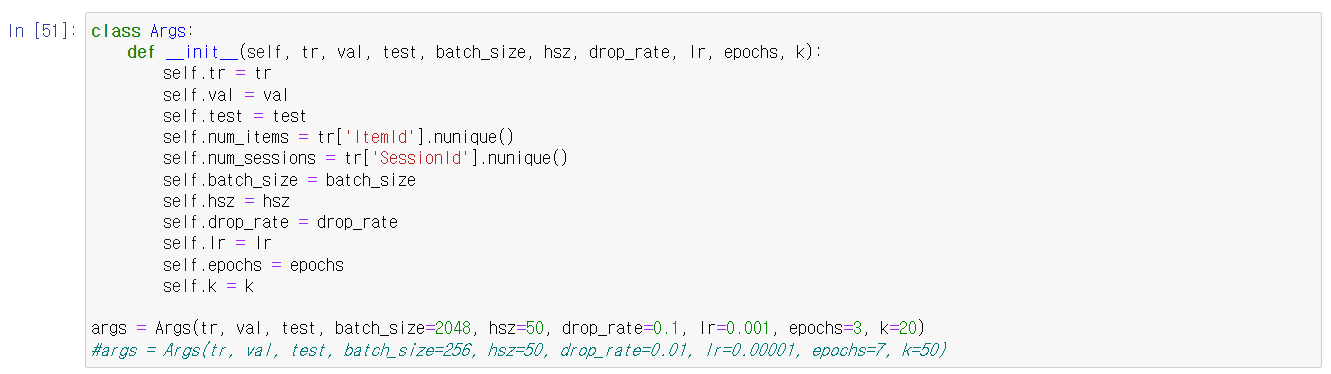
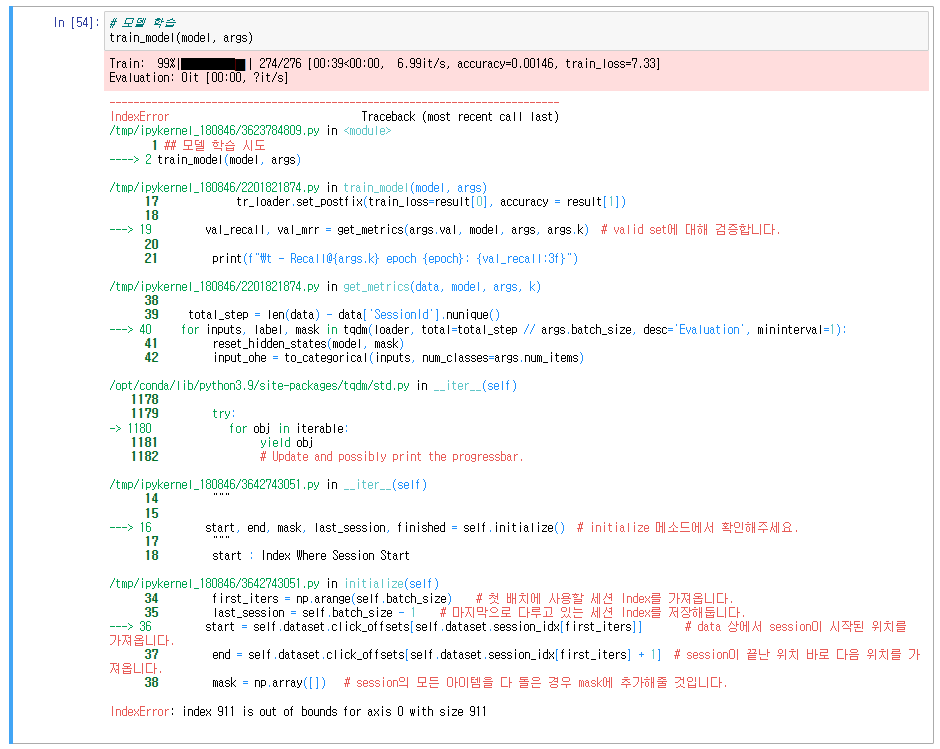